In [1]:
path = "c:/Users/Nathalie/Nextcloud/LADi/Orthografie Trainer/Code/04_bias_mitigation/"

import sys

sys.path.insert(1, path + "classes")

from DecisionTree_insession import in_session_decision_tree
from KNN_insession import in_session_KNN
from MLP_insession import in_session_MLP
from MetricsClass import Evaluation
from Plotting import Plots

import pandas as pd
import seaborn as sns
import pickle

Representational Bias Mitigation: Balance out dataset

In [ ]:
# define feature cols
feature_cols = [
    "Erstloesung",
    "Schussel",
    "Erfolg",
    "Schwierigkeit",
    "ist_Schulzeit",
    "MehrfachFalsch",
    "vorher_abgebrochen",
    "Fehler",
    "Klassenstufe",
    "Jahredabei",
    "AnzahlAufgaben",
    "Sex__m",
    "Sex__w",
    "Testposition__pruefung",
    "Testposition__training",
    "Testposition__version",
    "Art__GK",
    "Art__GR",
    "Art__GZ",
    "Art__K",
    "Art__LB",
    "UserAttribut",
    "OrderNumber",
    "steps",
]

c:\Users/Nathalie/Nextcloud/LADi/Orthografie Trainer/Code/04_bias_mitigation/classes\Plotting.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentence_len = sentence_len.append({"Sentence": x, "Count": l}, ignore_index=True)
c:\Users/Nathalie/Nextcloud/LADi/Orthografie Trainer/Code/04_bias_mitigation/classes\Plotting.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentence_len = sentence_len.append({"Sentence": x, "Count": l}, ignore_index=True)
c:\Users/Nathalie/Nextcloud/LADi/Orthografie Trainer/Code/04_bias_mitigation/classes\Plotting.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentence_len = sentence_len.append({"Sentence": x, "Count": l}, ignore_index=True)
c:\Users/Nathalie/Nextcloud/LADi/Orthografi

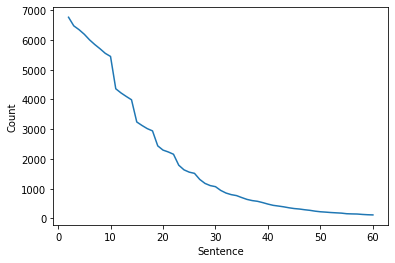

In [2]:
# plot count of sentences per matrix
Plot = Plots()
Plot.plot_count_of_sentences_per_matrix(2,61,"AbiEltern_allsessions/matrix")

Decision Tree Classifier

In [ ]:
DTE = in_session_decision_tree()
DTE.set_range(2, 61) 
DTE.set_majority_group("AbiEltern")
DTE.set_demographic_category("AbiEltern")

DTE.load_matrices(
    "03_representational_bias_mitigation/AbiEltern_allsessions/matrix", ".pkl", True
)

DTE.set_feature_cols(
    feature_cols
)

DTE.set_majority_group("keinAbi")
DTE.set_minority_group("abi")

metrics_DTE = DTE.loop_matrices("AbiEltern_allsessions/matrix",5,1,2)

KNN

In [ ]:
KNN = in_session_KNN()
KNN.set_range(2, 61) 

KNN.set_majority_group("AbiEltern")
KNN.set_demographic_category("AbiEltern")

# not balanced out, as representational bias is not attempted to be mitigated yet
KNN.load_matrices(
    "03_representational_bias_mitigation/AbiEltern_allsessions/matrix", ".pkl", True
)
KNN.set_feature_cols(
    feature_cols
)
KNN.set_majority_group("keinAbi")
KNN.set_minority_group("abi")
metrics_KNN = KNN.loop_matrices("AbiEltern_allsessions/matrix",2,'uniform')

MLP

In [ ]:
MLP = in_session_MLP()
MLP.set_range(2, 61)  

MLP.set_majority_group("AbiEltern")
MLP.set_demographic_category("AbiEltern")

# not balanced out, as representational bias is not attempted to be mitigated yet
MLP.load_matrices(
    "03_representational_bias_mitigation/AbiEltern_allsessions/matrix", ".pkl", True
)
MLP.set_feature_cols(
    feature_cols
)
MLP.set_majority_group("keinAbi")
MLP.set_minority_group("abi")
metrics_MLP = MLP.loop_matrices("AbiEltern_allsessions/matrix",'Adam','binary_crossentropy','accuracy',24,24)

In [ ]:
metrics_MLP

In [ ]:
## construct dfs for all groups from metric df
metrics = pd.concat([metrics_DTE, metrics_KNN, metrics_MLP])
grouped = metrics.groupby(metrics.group)
df_all = grouped.get_group("all")

In [ ]:
## plot accuracy by n and model
ax = sns.lineplot(data=df_all, x="Sentence", y="Accuracy", hue="model")

In [ ]:
## plot count of sentences by n and model
ax = sns.lineplot(data=df_all, x="Sentence", y="Length", hue="model")

Evaluate

In [ ]:
# evaluate metrics for fairness
evaluation_obj = Evaluation(metrics)
evaluation_obj.set_demographic_category("AbiEltern")
evaluation_obj.set_minority_group("abi")
evaluation_obj.set_majority_group("keinAbi")
df_abi = evaluation_obj.evaluate()

In [ ]:
# show table
table = evaluation_obj.showTable(df_abi)
table

In [ ]:
## save results
writer = pd.ExcelWriter("df_abiEltern.xlsx", engine="xlsxwriter")
df_abi.to_excel(writer, sheet_name="AbiEltern")
writer.save()